# Analyze landfast ice using E_FA

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from landfast_ice_detection import landfast_ice_detection
from datetime import date 
import datetime
from netCDF4 import Dataset
import cmocean.cm as cmo
from functions import plot_cartopy
import cv2


# input data directory
path = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc/')

# region of interest
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

### Construct the full file name:
# Since path is a `pathlib.Path` object, we can create the full path of the input file by 
# appending the name with a forward slash "/". We also use the `.format()` method to use
# the variable `region` in the string of the file name.
fname = path / '{}.nc'.format(region)

### Load data into a `xarray.Dataset`:
# Note that the data is loaded lazily which means that no actual data are actually written
# into memory.
ds = xr.open_dataset(fname)

# subset `xarray.Dataset` by index
ds = ds.isel(x=slice(1700, None), y=slice(600, 1450))


# create shortcuts to the variables
lon = ds.longitude
lat = ds.latitude
juld = ds.juld
land = ds.land
E_FA = ds['E_FA']
E_CT = ds['E_CT']

## Function for obtaining LF area and coordinates using OpenCV

In [332]:
def sina_detection(date_str):
    # Coastline detection

    ret, thresh = cv2.threshold(land.values,       # src
                                0.5,               # thresh
                                1,                 # maxval
                                cv2.THRESH_BINARY) # type

    contours, hierarchy = cv2.findContours(thresh.astype(np.uint8), # image
                                           cv2.RETR_EXTERNAL,       # mode
                                           cv2.CHAIN_APPROX_NONE)   # method

#     print('I found {} contours'.format(len(contours)))

    # pick the largest contour and assume it is surrounding the land
    cland = np.squeeze(max(contours, key=cv2.contourArea))

    # x- and y-indices of the land contour
    xinds = xr.DataArray(cland[:,0], dims=['coastline'])
    yinds = xr.DataArray(cland[:,1], dims=['coastline'])

    # longitude and latitude of the land contour
    lon_cland = lon.isel(x=xinds, y=yinds)
    lat_cland = lat.isel(x=xinds, y=yinds)

    # we manually find the minimum and maximum indexes of the coastline of interest
    indmin = 2087
    indmax = None

    # get longitude and latitude of coastline of interest
    lon_coast = lon_cland.isel(coastline=slice(indmin, indmax))
    lat_coast = lat_cland.isel(coastline=slice(indmin, indmax))

    # Sina detection

    # create a binary image where all grid points that are not land or have CT = 11 are
    # set to zero. (Technically, we could skip this step, because our input "image" is
    # already binary.)
    FA = E_FA.sel(juld=date_str)
    FA_sina = CT.fillna(8).where((FA==8) | (land==1), other=0)
    # FA_sina = FA.where((FA == 8), other=0)
    # FA = E_FA.sel(juld='2020-04-27')
    # FA = FA.where(FA == 8, other=np.nan)
    ret, thresh = cv2.threshold(FA_sina.values,    # src
                                7,                # thresh
                                8,                # maxval
                                cv2.THRESH_BINARY) # type\

    # find the contours
    contours, hierarchy = cv2.findContours(thresh.astype(np.uint8), # image
                                           cv2.RETR_EXTERNAL,       # mode
                                           cv2.CHAIN_APPROX_NONE)   # method

    # Since the land grid points are part of this contour, we assume again that the
    # contour of interest is the larges one.
    tmp = np.squeeze(max(contours, key=cv2.contourArea))

    # x- and y-indices of the land+sina contour
    xinds = xr.DataArray(tmp[:,0], dims=['coastline'])
    yinds = xr.DataArray(tmp[:,1], dims=['coastline'])

    # longitude and latitude of the land+sina contour
    lon_edge = lon.isel(x=xinds, y=yinds)
    lat_edge = lat.isel(x=xinds, y=yinds)

    # The exclusive interesection between the contour `tmp` and the land contour `cland`
    # is the landfast sea ice "sina"

    # Generate masks of both contours
    msk_tmp = cv2.drawContours(np.zeros(FA.shape, np.uint8), [tmp], 0, 1, cv2.FILLED)
    msk_cland = cv2.drawContours(np.zeros(FA.shape, np.uint8), [cland], 0, 1, cv2.FILLED)

    # Now we find all the grid points that are contained in both masks
    sina = cv2.bitwise_xor(msk_tmp, msk_cland)

    # Create a xr.DataArray with the same dimensions and coordinates as the original data.
    # We are also masking out the land and area where we didnt have any data.
    sina = xr.DataArray(data=sina, dims=FA.dims, coords=FA.coords).where(land==0)

    # In this array all grid points with landfast sea ice are equal to one. Since each grid
    # cell represents an area of 1 km^2, we can get the total area of sina by computing
    # the sum:
    sina_area = sina.sum()

#     print('The total area of landfast sea ice is {} km^2'.format(sina_area.values))

    # create plot
#     fig, ax = plt.subplots(1, 1, figsize=(7.5, 9), subplot_kw={'projection': rot})
#     ax.set_extent([-61.5, -56.5, 53.8, 61.5])
#     ax.contourf(lon, lat, sina, transform=ccrs.PlateCarree())

    # x-and y coordinates of coastline and landfast ice edge as complex numbers
    a = lon_coast.x + 1j * lon_coast.y 
    b = lon_edge.x + 1j * lon_edge.y

    # a is a "vector" of length N, where N is the number of grid points along the coast.
    # b is a "vector" of length M, where M is the number of grid points along the ice edge.

    # create a MxN matrix where each row is a copy of a
    A = np.array([a,] * len(b))

    # create a NxM matrix where each row is a copy of b
    B = np.array([b,] * len(a)) # NxM matrix 

    # Flatten the arrays which means that we append all rows an array  into one "vector".
    # Note that we take the transpose of B before we flatten the array.
    cst = A.flatten()
    edge = B.T.flatten()

    # Both "vectors" now have the same number (NxM) of elements that are all possible
    # combinations of grid points along the coast and ice edge.

    # Since the coordinates are complex numbers it is straightforward to calculate the distances
    # between all grid points along the coast and along the ice edge. By reshaping the "vector"
    # back into a MxN 
    dst = np.abs(cst - edge).reshape((len(b), -1))


    # find unique indices of grid points along the ice edge where the distance to land
    # is shortest
    edge_ind = np.unique(np.argmin(dst, axis=0))

    # select the part of the ice edge that is between the first and last of those indices
    lf_lon = lon_edge.isel(coastline=slice(edge_ind[0], edge_ind[-1]))
    lf_lat = lat_edge.isel(coastline=slice(edge_ind[0], edge_ind[-1]))

    # select only those points along the ice edge that are closest to land
    shortest_lon = lon_edge.isel(coastline=edge_ind)
    shortest_lat = lat_edge.isel(coastline=edge_ind)
    
    return lf_lon, lf_lat, sina_area, lon_coast, lat_coast

    # create plot
#     fig, ax = plt.subplots(1, 1, figsize=(20, 20), subplot_kw={'projection': rot})
#     ax.set_extent([-61.5, -56.5, 53.8, 61.5])

#     #Declare the land and ocean parameters
#     LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
#     edgecolor='black',
#     facecolor=('silver'),
#     linewidth=1)
#     OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
#     facecolor='dimgrey')

#     ax.add_feature(LAND_highres,zorder=2)
#     ax.add_feature(OCEAN_highres,zorder=3)
#     ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)

#     cs = ax.contourf(lon, lat, FA,
#                      vmin=0,
#                      vmax=12,
#                      cmap=cmo.ice,
#                      transform=ccrs.PlateCarree(),
#                      zorder=4)
#     ax.plot(shortest_lon, shortest_lat,
#             '.', color='C1',
#             transform=ccrs.PlateCarree(),
#             zorder=4)
#     ax.plot(lf_lon, lf_lat,
#             color='k',
#             linewidth=2,
#             transform=ccrs.PlateCarree(),
#             zorder=4)

#     plt.colorbar(cs, ax=ax)

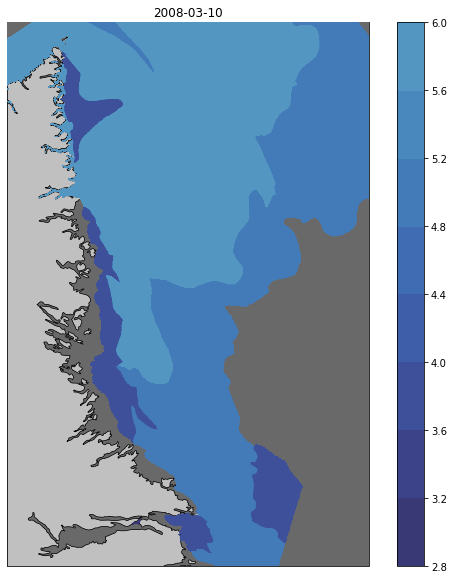

In [383]:
# create plot
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': rot})
ax.set_extent([-61.5, -56.5, 53.8, 61.5])

#Declare the land and ocean parameters
LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
edgecolor='black',
facecolor=('silver'),
linewidth=1)
OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
facecolor='dimgrey')

ax.add_feature(LAND_highres,zorder=2)
ax.add_feature(OCEAN_highres,zorder=3)
ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)

FA = E_FA.sel(juld='2008-3-10')
FA_sina = CT.fillna(8).where((FA==8) | np.isnan(FA), other=0)

cs = ax.contourf(lon, lat, FA,
                 vmin=1,
                 vmax=9,
                 cmap=cmo.ice,
                 transform=ccrs.PlateCarree(),
                 zorder=4)
# ax.plot(shortest_lon, shortest_lat,
#         '.', color='C1',
#         transform=ccrs.PlateCarree(),
#         zorder=4)
# ax.plot(lf_lon, lf_lat,
#         color='k',
#         linewidth=2,
#         transform=ccrs.PlateCarree(),
#         zorder=4)

plt.colorbar(cs, ax=ax)
plt.title('2008-03-10')
plt.savefig('FA_2008-3-10')

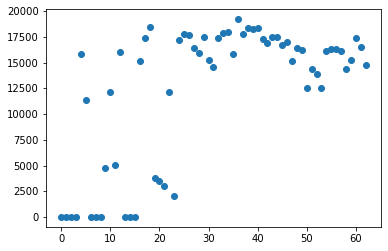

In [375]:
plt.plot(AREA,'o')

In [385]:
AREA

[<xarray.DataArray ()>
 array(15.)
 Coordinates:
     juld     datetime64[ns] 1997-03-01,
 <xarray.DataArray ()>
 array(15.)
 Coordinates:
     juld     datetime64[ns] 1998-03-01,
 <xarray.DataArray ()>
 array(15.)
 Coordinates:
     juld     datetime64[ns] 1999-03-01,
 <xarray.DataArray ()>
 array(15.)
 Coordinates:
     juld     datetime64[ns] 2000-03-01,
 <xarray.DataArray ()>
 array(15823.)
 Coordinates:
     juld     datetime64[ns] 2001-03-01,
 <xarray.DataArray ()>
 array(11330.)
 Coordinates:
     juld     datetime64[ns] 2002-03-01,
 <xarray.DataArray ()>
 array(15.)
 Coordinates:
     juld     datetime64[ns] 2003-03-01,
 <xarray.DataArray ()>
 array(15.)
 Coordinates:
     juld     datetime64[ns] 2004-03-01,
 <xarray.DataArray ()>
 array(15.)
 Coordinates:
     juld     datetime64[ns] 2005-03-01,
 <xarray.DataArray ()>
 array(4773.)
 Coordinates:
     juld     datetime64[ns] 2006-03-01,
 <xarray.DataArray ()>
 array(12173.)
 Coordinates:
     juld     datetime64[ns] 2006-03-15,

### Apply function over multiple years

In [318]:
# Only plot fast ice using E_FA, where code 8 = landfast ice
mon = 3
# FFA = []
LF_LON = []
LF_LAT = []
AREA = []
date_str = []
cnt=0
for yr in years_unique:
    # Every year for the month defined by mon
    which = (years == yr) * (np.array(months) == mon)
    if np.sum(which) >= 1:
        # Save all observational days of the month
        tt = np.where(which)[0]
    for k in tt:
        date_str.append(dates[k].strftime("%Y-%m-%d"))
        lf_lon, lf_lat, sina_area, lon_coast, lat_coast = sina_detection(date_str[cnt])
        AREA.append(sina_area)
        LF_LON.append(lf_lon)
        LF_LAT.append(lf_lat)
#         FA = E_FA.sel(juld=date_str[cnt])
#         t.append(k)  
#         FFA.append(FA.where(FA == 8, other=np.nan))
        
        cnt +=1

In [334]:
lf_lon, lf_lat, sina_area, lon_coast, lat_coast = sina_detection(date_str[0])

## Old function using grid point iteration

In [ ]:
# Which month?
mon = 3


m = np.shape(FA)[2]
n = np.shape(FA)[1]

sina_ii = np.zeros((m))
sina_jj = np.zeros((m))

sina_i = []
sina_j = []
dates_sina = []
juld_sina = []

# Mask lon and lat to get land               
ma_lon = ma.masked_array(lon, mask=land)
ma_lat = ma.masked_array(lat, mask=land)

for yr in years_unique:
    # Every year for the month defined by mon
    which = (years == yr) * (np.array(months) == mon)
    if np.sum(which) >= 1:
        # Save all observational days of the month
        tt = np.where(which)[0]
    for k in tt:
        sina_ii = np.zeros((m))
        sina_jj = np.zeros((m))
        for i in range(m):
            # Where there is ice
            not_nans = np.where(np.isnan(FA[k,:,i])==False)[0]
            sina_ii[i] = i
            # Check: Is there landfast ice in row i (FA=100)? If yes, save first index as sina point
            if 100.0 in FA[k,:,i]:
                # Don't count other regions of FA=100. Reverse so coming from west

                sina_point = np.where(FA[k,:,i]==100.0)[0][0]
                    
                ###
                
                # If the index is more west than the defined coastline, save coastline instead
                if sina_point <= coast_j[i]:
                    sina_jj[i] = sina_point
                else: 
                    sina_jj[i] = coast_j[i]
                
            # SHOULD there be LF ice? (Is there a gap between last FA point and coastline?)
            # Check: Is the coastline at the same location as last ice?
            # First non-nan ice value along j
            
            # Make sure there are non-nan values
            elif 8 not in FA[k,:,i] and len(not_nans)>0:
                last_ice = not_nans[-1]
                # If not at coastline, save as Sina, unless it's too far to be the true Sina (110km)
                if last_ice < coast_j[i]:# and abs(coast_j[i] - last_ice) < 97:
                    sina_jj[i] = last_ice
                else:
               # If the LF ice in FA is more west than the coastline, fill index with coastline coordinate.
                    if ma_lon[:,i].count() !=0: 
                        sina_jj[i] = coast_j[i]
            # If row is all nans:
            else:
                if ma_lon[:,i].count() !=0: 
                    sina_jj[i] = coast_j[i]
                
        sina_ii = sina_ii.astype(int)
        sina_jj = sina_jj.astype(int)
        dates_sina.append(dates[k])
        juld_sina.append(juld[k])
        sina_i.append(sina_ii)
        sina_j.append(sina_jj)